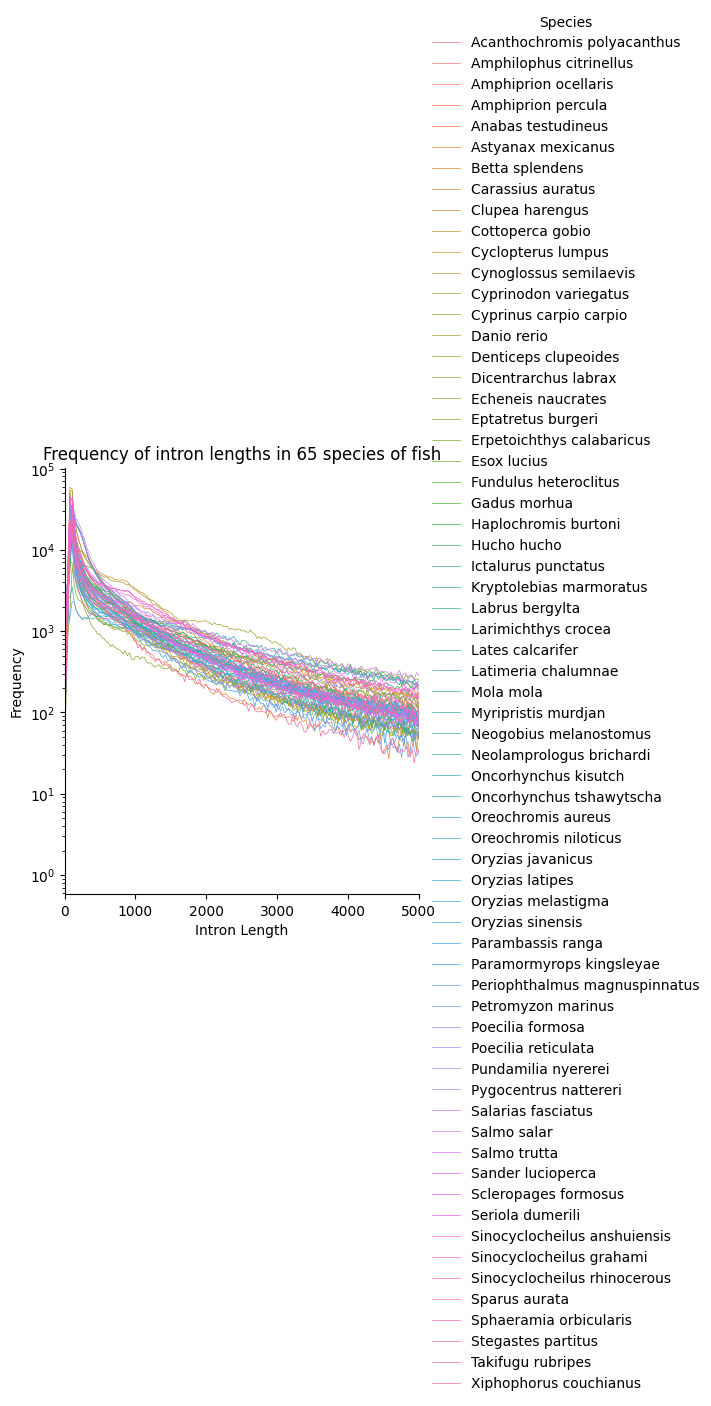

In [ ]:
import pandas as pd
import psutil

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# don't read from open csv files
open_csv_files = []
for proc in psutil.process_iter():
    try:
        flist = proc.open_files()
        if flist:
            for nt in flist:
                if "csv" in nt.path:
                    open_csv_files.append(Path(nt.path).name)
    except Exception as err:
        pass

data_directory = "../perl_data"
output_directory = "../perl_output"
filenames = (Path(".").parent).joinpath(data_directory).rglob("*.csv")
csv_files = []
for filename in filenames:
    if not Path(filename).name in open_csv_files:
        csv_files.append(filename)
introns_data_df = pd.concat(
    (pd.read_csv(f) for f in sorted(csv_files)[:-1]), ignore_index=True
)
introns_data_df
bins = list(range(0, introns_data_df["Length"].max(), 30))
groups = introns_data_df.groupby(
    ["Species", pd.cut(introns_data_df.Length, bins)], observed=True
)
introns_df = groups.size().reset_index(name="Counts")
introns_df["Length"] = introns_df.apply(
    lambda row: (row["Length"].left + row["Length"].right) / 2, axis=1
)
plot = sns.relplot(
    data=introns_df,
    x="Length",
    y="Counts",
    hue="Species",
    kind="line",
    linewidth=0.5,
    errorbar=None,
    markers=True,
)
plot.set(
    title="Frequency of intron lengths in {} species of fish".format(
        len(introns_df["Species"].unique())
    ),
    xlabel="Intron Length",
    ylabel="Frequency",
    yscale="log",
    xlim=[0, 5000],
)
labels = zip(
    plot.legend.get_texts(),
    introns_df["Species"]
    .apply(lambda row: row.capitalize().replace("_", " "))
    .unique()
    .tolist(),
)
for text, label in labels:
    text.set_text(label)
    text.set_fontsize("xx-small")
    text.set_fontstyle("italic")
plot.figure.savefig((Path(".").parent).joinpath(output_directory, "all_species_introns.png"), dpi=600)